# Final Modeling Using Batches

The goal of my capstone is to be able to predict Lithium-Ion battery life before any capacity degradation. This entails reading data from only the first 100 cycles for any battery, and predicting it's cycle life (which is 80% capacity).

Similarly to the process used by the Stanford Research team, we have three batches.

Batch 1 will be used to train the model and begin hyper parameter optimization.

Batch 2 will be used to further optimize hyper parameters to gain a better model fit.

And lastly, Batch 3 will be used as the final metric for our model.

## Table of Contents

* [Small Scale Linear Regression](#chapter1)
    * [Feature Engineering](#section1_1)
* [Building Batch Model](#chapter2)
    * [Using Ensemble Methods](#section2_1)
    * [Optimizing Hyper Parameters](#section2_2)
    * [Making Predictions](#section2_3)
    * [First MAPE](#section2_4)
* [Testing on Batch 2](#chapter3)
    * [Accuracy Tests](#section3_1)
        * [Accuracy and Prediction on Batch 2 Cell 7](#section3_1_1)
        * [Accuracy and Prediction on Batch 2 Cell 9](#section3_1_2)
    * [MAPE on Batch 2](#section3_2)
* [Model Improvement](#chapter4)
    * [MAPE Predictions](#section4_1)
    * [Model Improvement II](#section4_2)
    * [MAPE Predictions II](#section4_3)
    * [Bagging Regressor with PCA](#section4_4)
* [Batch 3 MAPE](#chapter5)
* [Conclusion](#chapter6)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

## Read in Data

Similarly to the process used by the Stanford research team, I will be using our first batch to develop and tune the model as well as it's parameters

In [2]:
batch_1 = pd.read_pickle('data/batch1.pkl')

In [3]:
b1_df = pd.DataFrame(batch_1)

In [4]:
b1_df

,b1c0,b1c1,b1c2,b1c3,b1c4,b1c5,b1c6,b1c7,b1c8,b1c9,...,b1c36,b1c37,b1c38,b1c39,b1c40,b1c41,b1c42,b1c43,b1c44,b1c45
cycle_life,[[1190.0]],[[1179.0]],[[1177.0]],[[1226.0]],[[1227.0]],[[1074.0]],[[636.0]],[[870.0]],[[879.0]],[[1054.0]],...,[[704.0]],[[648.0]],[[617.0]],[[625.0]],[[966.0]],[[1051.0]],[[702.0]],[[651.0]],[[616.0]],[[599.0]]
charge_policy,3.6C(80%)-3.6C,3.6C(80%)-3.6C,3.6C(80%)-3.6C,4C(80%)-4C,4C(80%)-4C,4.4C(80%)-4.4C,4.8C(80%)-4.8C,4.8C(80%)-4.8C,5.4C(40%)-3.6C,5.4C(40%)-3.6C,...,7C(40%)-3C,7C(40%)-3C,7C(40%)-3.6C,7C(40%)-3.6C,8C(15%)-3.6C,8C(15%)-3.6C,8C(25%)-3.6C,8C(25%)-3.6C,8C(35%)-3.6C,8C(35%)-3.6C
summary,"{'IR': [0.0, 0.016742354, 0.016724309, 0.01668...","{'IR': [0.0, 0.017038831, 0.017009802, 0.01692...","{'IR': [0.0, 0.01686798, 0.016831938, 0.016718...","{'IR': [0.0, 0.016369704, 0.016315572, 0.01632...","{'IR': [0.0, 0.016787428, 0.016740341, 0.01673...","{'IR': [0.0, 0.016437579, 0.016396422, 0.01636...","{'IR': [0.0, 0.017001977, 0.016977131, 0.01693...","{'IR': [0.0, 0.016311171, 0.016267659, 0.01623...","{'IR': [0.0, 0.016807221, 0.016761683, 0.01674...","{'IR': [0.0, 0.016978227, 0.01692898, 0.016933...",...,"{'IR': [0.0, 0.016480684, 0.016444681, 0.01641...","{'IR': [0.0, 0.016607935, 0.016576257, 0.01654...","{'IR': [0.0, 0.016260354, 0.016216327, 0.01618...","{'IR': [0.0, 0.016743599, 0.016682221, 0.01669...","{'IR': [0.0, 0.016756468, 0.016708069, 0.01670...","{'IR': [0.0, 0.016856873, 0.016819723, 0.01676...","{'IR': [0.0, 0.0167679, 0.016730737, 0.0166876...","{'IR': [0.0, 0.016111452, 0.01610712, 0.016078...","{'IR': [0.0, 0.017436398, 0.017408649, 0.01736...","{'IR': [0.0, 0.016685704, 0.016654616, 0.01661..."
cycles,"{'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...","{'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...","{'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...","{'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...","{'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...","{'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...","{'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...","{'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...","{'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...","{'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...",...,"{'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...","{'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...","{'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...","{'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...","{'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...","{'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...","{'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...","{'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...","{'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...","{'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]..."


In [5]:
b1_df['b1c0']['cycles']['0'].keys()

dict_keys(['I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'dQdV', 't'])

These will be the features for our model, please refer to `EDA.ipynb` for more details on them.

## Small Scale Linear Regression <a class="anchor" id="chapter1"></a>

We start by running a small scale linear regressions using the interpolated cycle data.

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Feature Engineering<a class="anchor" id="section1_1"></a>

A quick rundown of EDA observations: We choose to use the interpolated cycle data and take the means of each feature for our model. We use the cycle data as it contains higher quality information than the summary data, and we use means because the 1000+ readings each cycle contains can confuse the model.

In [7]:
for i in b1_df['b1c0']['cycles']['1']:
    print(f"{i}: {(b1_df['b1c0']['cycles']['1'][i]).mean()}")

I: -0.09543858846402112
Qc: 0.8303641735283717
Qd: 0.27206403873353263
Qdlin: 0.7441887504721483
T: 31.875010776448942
Tdlin: 33.46726262565514
V: 3.121950578104876
dQdV: -0.7398129777987291
t: 26.317435098129415


In [8]:
for i in b1_df['b1c6']['cycles']['1']:
    print(f"{i}: {(b1_df['b1c6']['cycles']['1'][i]).mean()}")

I: -0.03311658898964286
Qc: 0.8551961071092244
Qd: 0.2896235255753702
Qdlin: 0.7455987614406143
T: 32.512973754771
Tdlin: 33.82635182125009
V: 3.1188565417938934
dQdV: -0.7407086342988392
t: 24.740315268765897


We will be creating a dataframe with the mentioned data transformations as well as a `cycles_to_end` feature, which we will be testing for. I have found that the `cycles_to_end` feature provides us with a solid framework to have the model read data from the first 100 cycles and be able to get a MAPE with the true cycle life. This is essentially a "distance to end" metric which the model can learn about, it uses the listed `cycle_life` for the cell and subtracts the current cycle number for that iteration.

This is purely a homebrew approach, Stanford research used an n-dimensional matrix as their target variable which contained all of the of observed cycle lifetime, but I could not achieve that.

In [9]:
cycle_dict = {'I':[], 'Qc':[], 'Qd':[], 'Qdlin':[], 'T':[], 'Tdlin':[], 'V':[], 'dQdV':[], 't':[], 'cycles_to_end':[]}

# Iterate over each cycle
for cycle in b1_df['b1c0']['cycles']:
    # Cycle 0 data not used as all values are 0, which may result in model confusion
    if cycle == '0':
        pass
    else:
        # Add the means of each feature for that cycle to dictionary
        for feature in b1_df['b1c0']['cycles'][cycle]:
            cycle_dict[feature].append((b1_df['b1c0']['cycles'][cycle][feature]).mean())
        # Add the number cycles till end of life to dictionary as well
        cycle_dict['cycles_to_end'].append(b1_df['b1c0']['cycle_life'][0][0] - int(cycle))

In [10]:
# Check cycle_dict was formed correctly
for i in cycle_dict:
    print(len(cycle_dict[i]))

1188
1188
1188
1188
1188
1188
1188
1188
1188
1188


In [11]:
cycle_df = pd.DataFrame(cycle_dict)

In [12]:
# Check
cycle_df

,I,Qc,Qd,Qdlin,T,Tdlin,V,dQdV,t,cycles_to_end
0,-0.095439,0.830364,0.272064,0.744189,31.875011,33.467263,3.121951,-0.739813,26.317435,1189.0
1,-0.119712,0.835266,0.281724,0.745483,31.931490,33.519392,3.118179,-0.735382,26.702425,1188.0
2,-0.200550,0.838370,0.283037,0.745862,31.932603,33.521738,3.118349,-0.741850,26.860709,1187.0
3,-0.157016,0.842304,0.279682,0.746767,31.959322,33.530691,3.119878,-0.743376,26.766272,1186.0
4,-0.150986,0.839470,0.283320,0.747357,31.961062,33.549148,3.121280,-0.735837,26.819928,1185.0
...,...,...,...,...,...,...,...,...,...,...
1183,-0.177729,0.801412,0.274873,0.696912,32.305923,33.639638,3.107696,-0.693700,24.356896,6.0
1184,-0.167174,0.793915,0.272783,0.696887,32.307072,33.560894,3.104457,-0.691821,24.665744,5.0
1185,-0.073789,0.790342,0.266145,0.696946,32.296148,33.652992,3.106309,-0.696074,24.206912,4.0
1186,-0.082826,0.798092,0.264379,0.696755,32.208778,33.618957,3.114085,-0.698494,24.860452,3.0


Our data was read correctly, we start by running a naive small scale linear regression to compare the predictive power of one battery's information on another.

In [13]:
X = cycle_df.drop(['cycles_to_end'], axis=1)
y = cycle_df['cycles_to_end']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [14]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_ss = scaler.transform(X_train)
X_test_ss = scaler.transform(X_test)

In [15]:
cycle_linReg = LinearRegression()
cycle_linReg.fit(X_train_ss, y_train)
cycle_linReg.score(X_train_ss, y_train)

0.9893283829316402

In [16]:
cycle_linReg.score(X_test_ss, y_test)

0.9873093896920714

A model trained on a single battery can predict it's own cycle life accurately, let's see how that prediction translates to another battery. (Note: we test on batch 1, cell 1, a battery with similar cycle life, to ensure our features are grounded in cycle life)

In [17]:
test_dict = {'I':[], 'Qc':[], 'Qd':[], 'Qdlin':[], 'T':[], 'Tdlin':[], 'V':[], 'dQdV':[], 't':[], 'cycles_to_end':[]}
test_battery = 'b1c1'
for cycle in b1_df[test_battery]['cycles']:
    if cycle == '0':
        pass
    else:
        for feature in b1_df[test_battery]['cycles'][cycle]:
            test_dict[feature].append((b1_df[test_battery]['cycles'][cycle][feature]).mean())
        test_dict['cycles_to_end'].append(b1_df[test_battery]['cycle_life'][0][0] - int(cycle))

In [18]:
test_df = pd.DataFrame(test_dict)

In [19]:
# Check
test_df

,I,Qc,Qd,Qdlin,T,Tdlin,V,dQdV,t,cycles_to_end
0,-0.101862,0.835722,0.277370,0.746403,31.668844,32.810588,3.120523,-0.744858,26.512294,1178.0
1,-0.177891,0.841977,0.283030,0.747583,31.722740,32.886497,3.117998,-0.743793,26.826679,1177.0
2,-0.139141,0.840273,0.281128,0.747954,31.748258,32.999867,3.117845,-0.738087,26.713875,1176.0
3,-0.171255,0.847151,0.282450,0.749325,31.773122,32.964164,3.119954,-0.741797,26.921384,1175.0
4,-0.151756,0.839471,0.279450,0.750014,31.767231,33.009156,3.117434,-0.738450,26.627582,1174.0
...,...,...,...,...,...,...,...,...,...,...
1172,-0.117749,0.808709,0.264188,0.704393,31.794478,32.803250,3.117516,-0.702097,24.914018,6.0
1173,-0.144068,0.809633,0.269149,0.704429,31.919857,33.023771,3.121047,-0.701596,25.669715,5.0
1174,-0.068192,0.802940,0.260188,0.704506,31.912174,32.940017,3.125393,-0.697455,24.868359,4.0
1175,-0.085123,0.806344,0.273577,0.704343,31.935913,32.775518,3.110698,-0.693757,24.998401,3.0


In [20]:
X = test_df.drop(['cycles_to_end'], axis=1)
y = test_df['cycles_to_end']

In [21]:
scaler = StandardScaler()
scaler.fit(X)
X_ss = scaler.transform(X)

In [22]:
cycle_linReg.score(X_ss, y)

0.9827360291666286

Using interpolated data is showing potential. The features do maintain predictive power across batteries with similar cycle lives, meaning batteries with similar cycle lives should have comparable feature values. In our `ModelFailures.ipynb`, you'll see we were at 83% accuracy at this stage with summary data; hence why we decided to work with cycle data.

## Building Batch Model<a class="anchor" id="chapter2"></a>

To build a model and train it on Batch 1, we need to read in the data for each battery and sensibly form an aggregate dataframe with it all. I decided to use the same process as I did for the naive linear regression, as it maintains `cycles_to_end` as our target variable, and gives our model more information on the various states of our features to predict with.

In [23]:
batch_dict = {'I':[], 'Qc':[], 'Qd':[], 'Qdlin':[], 'T':[], 'Tdlin':[], 'V':[], 'dQdV':[], 't':[], 'cycles_to_end':[]}

# Iterate over each cell
for cell in b1_df:
    # Iterate over the cycles for each cell
    for cycle in b1_df[cell]['cycles']:
        # Again, skip the first cycle, with no information
        if cycle == '0':
            pass
        else:
            # Add the means of each feature for that cycle
            for feature in b1_df[cell]['cycles'][cycle]:
                batch_dict[feature].append((b1_df[cell]['cycles'][cycle][feature]).mean())
            # Add cycles_to_end to dictionary
            batch_dict['cycles_to_end'].append(b1_df[cell]['cycle_life'][0][0] - int(cycle))

In [24]:
batch_dict

{'I': [-0.09543858846402112,
  -0.1197118039690812,
  -0.20055007618110038,
  -0.15701563118490947,
  -0.15098582519048429,
  -0.09680419072677958,
  -0.1416670144507709,
  -0.10798809398898002,
  -0.09979672097528564,
  -0.10173803651077584,
  0.045461283296624896,
  -0.09570104827961066,
  -0.13598532417274345,
  -0.09608184333651114,
  -0.16268729401134807,
  -0.09514888093086787,
  -0.1317880785914908,
  -0.11258657116573356,
  -0.0797688803995255,
  -0.056829431592472834,
  -0.07214501774031265,
  -0.07410627388463757,
  -0.0791825131923708,
  -0.16990162203725614,
  -0.11760258221370741,
  -0.1520221523527393,
  -0.11342043915575997,
  -0.1394617553959251,
  -0.17384386202971777,
  -0.15861516352690855,
  -0.06349739357049775,
  -0.07937111337899333,
  -0.12385802501676124,
  -0.1704574081980124,
  -0.09402785051034014,
  -0.14085677167250593,
  -0.11089970732029308,
  -0.153101033749827,
  -0.12777890415608037,
  -0.09612455529304376,
  -0.06764815471988066,
  -0.137020133206121

In [25]:
batch_df = pd.DataFrame(batch_dict)

In [26]:
batch_df

,I,Qc,Qd,Qdlin,T,Tdlin,V,dQdV,t,cycles_to_end
0,-0.095439,0.830364,0.272064,0.744189,31.875011,33.467263,3.121951,-0.739813,26.317435,1189.0
1,-0.119712,0.835266,0.281724,0.745483,31.931490,33.519392,3.118179,-0.735382,26.702425,1188.0
2,-0.200550,0.838370,0.283037,0.745862,31.932603,33.521738,3.118349,-0.741850,26.860709,1187.0
3,-0.157016,0.842304,0.279682,0.746767,31.959322,33.530691,3.119878,-0.743376,26.766272,1186.0
4,-0.150986,0.839470,0.283320,0.747357,31.961062,33.549148,3.121280,-0.735837,26.819928,1185.0
...,...,...,...,...,...,...,...,...,...,...
38760,0.341908,0.701378,0.246561,0.518820,33.709809,34.216001,3.078970,-0.576723,22.573352,6.0
38761,-0.260398,0.752612,0.303895,0.518314,33.727794,34.233871,2.975409,-0.571760,24.987732,5.0
38762,-0.275233,0.752110,0.298243,0.517291,33.630904,34.189148,2.987913,-0.572194,25.239724,4.0
38763,0.269078,0.698146,0.256858,0.516178,33.715893,34.136295,3.059083,-0.549846,23.193376,3.0


Our batch data framework is ready for experimenting.

### Using Ensemble Methods<a class="anchor" id="section2_1"></a>

To make our model more robust, we will be using Ensemble methods, specifically bagging. A simple linear regression is highly likely to memorize the data for each cell and be unable to make an strong well-rounded prediction on other batteries.

In [27]:
from sklearn.ensemble import BaggingRegressor

In [28]:
X = batch_df.drop(['cycles_to_end'], axis=1)
y = batch_df['cycles_to_end']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [29]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_ss = scaler.transform(X_train)
X_test_ss = scaler.transform(X_test)

In [30]:
# We use 5 estimators for to improve the versatility of base linear regression
ensemble_of_linreg = BaggingRegressor(LinearRegression(), n_estimators=5, random_state=2)
ensemble_of_linreg.fit(X_train_ss, y_train)

BaggingRegressor(base_estimator=LinearRegression(), n_estimators=5,
                 random_state=2)

In [31]:
ensemble_of_linreg.score(X_train_ss, y_train)

0.6517088828847857

In [32]:
ensemble_of_linreg.score(X_test_ss, y_test)

0.6507126797039315

The predictive power of our model is not looking too good yet, but the fit does look promising, we can optimize hyper parameters for improvement. I'll note one last time, that using cycle data is better than the model based on summary data found in `ModelFailures.ipynb`, so we will continue using it in our final approach.

### Optimizing Hyperparameters<a class="anchor" id="section2_2"></a>

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [34]:
X = batch_df.drop(['cycles_to_end'], axis=1)
y = batch_df['cycles_to_end']

The parameters optimized for were `max_samples` (the percent of data points to train the base estimator) and `n_estimators` (the number of estimators used to train the model).

In [35]:
# Student Note: A model with optimized parameters is commented out below
# I apologize, but despite making the model with the recommended parameters,
# that model does not run the same. I have greatly trimmed down my GridSearch
# to make it quicker to run for you, please do so. This will be the case for later
# GridSearches as well; again I apologize for this.
estimators = [('scaler',StandardScaler()),('model',BaggingRegressor())]

mypipe = Pipeline(estimators)

param_grid = [{'model':[BaggingRegressor()],
             'model__max_samples':[.1,.25,.5,],
            'model__n_estimators' :[10,25,50],
              'model__random_state':[2]}]

grid = GridSearchCV(mypipe,param_grid,cv = 5)

fitted_grid_batch = grid.fit(X,y)

In [36]:
fitted_grid_batch.best_score_

0.8558498393883053

In [37]:
pd.DataFrame(fitted_grid_batch.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__max_samples,param_model__n_estimators,param_model__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,4.395227,0.124222,0.081341,0.011307,"BaggingRegressor(max_samples=0.25, n_estimator...",0.25,50,2,"{'model': BaggingRegressor(max_samples=0.25, n...",0.665524,0.919064,0.901646,0.922091,0.870924,0.855850,0.096884,1
0,0.375023,0.021956,0.016763,0.001588,"BaggingRegressor(max_samples=0.25, n_estimator...",0.1,10,2,"{'model': BaggingRegressor(max_samples=0.25, n...",0.678417,0.916568,0.899758,0.917328,0.861930,0.854800,0.090452,2
2,1.643456,0.008008,0.063157,0.008498,"BaggingRegressor(max_samples=0.25, n_estimator...",0.1,50,2,"{'model': BaggingRegressor(max_samples=0.25, n...",0.651763,0.924586,0.903937,0.927719,0.864082,0.854417,0.103838,3
1,0.837034,0.015770,0.032429,0.002914,"BaggingRegressor(max_samples=0.25, n_estimator...",0.1,25,2,"{'model': BaggingRegressor(max_samples=0.25, n...",0.658139,0.922784,0.902237,0.922417,0.862732,0.853662,0.100176,4
8,8.079857,0.164278,0.087541,0.008998,"BaggingRegressor(max_samples=0.25, n_estimator...",0.5,50,2,"{'model': BaggingRegressor(max_samples=0.25, n...",0.664790,0.915745,0.894142,0.920007,0.872164,0.853370,0.095822,5
4,2.127557,0.106872,0.038503,0.007638,"BaggingRegressor(max_samples=0.25, n_estimator...",0.25,25,2,"{'model': BaggingRegressor(max_samples=0.25, n...",0.652104,0.917769,0.899954,0.916962,0.871896,0.851737,0.101192,6
7,4.027730,0.086215,0.041088,0.006420,"BaggingRegressor(max_samples=0.25, n_estimator...",0.5,25,2,"{'model': BaggingRegressor(max_samples=0.25, n...",0.649284,0.914641,0.892304,0.923273,0.869225,0.849745,0.101974,7
3,0.821645,0.010154,0.016554,0.002410,"BaggingRegressor(max_samples=0.25, n_estimator...",0.25,10,2,"{'model': BaggingRegressor(max_samples=0.25, n...",0.633727,0.914679,0.892720,0.918591,0.867390,0.845421,0.107410,8
6,1.615457,0.036625,0.018750,0.002228,"BaggingRegressor(max_samples=0.25, n_estimator...",0.5,10,2,"{'model': BaggingRegressor(max_samples=0.25, n...",0.635122,0.912689,0.887551,0.923056,0.858982,0.843480,0.106506,9


In [38]:
# scaler = StandardScaler()
# scaler.fit(X)
# X_ss = scaler.transform(X)

In [39]:
# fitted_grid_batch = BaggingRegressor(max_samples=0.25, n_estimators=50, random_state=2)
# fitted_grid_batch.fit(X_ss,y)
# fitted_grid_batch.score(X_ss,y)

A 20% jump in accuracy from the crossfold is impressive, we can now check our predictive power.

### Making Predictions<a class="anchor" id="section2_3"></a>

Our predictions will be made using data from the first 100 cycle, and so we will only read in those first one hundred cycles. This is where the `cycles_to_end` feature shines as we can use the predictions made on that target to get a MAPE.

It is still not clear to me how the Stanford Research used data from the first 100 cycles in their matrix with observed cycle lives to make predicitons. My past model would memorize the observed cycle life and show further confusion.

In [40]:
test_dict = {'I':[], 'Qc':[], 'Qd':[], 'Qdlin':[], 'T':[], 'Tdlin':[], 'V':[], 'dQdV':[], 't':[], 'cycles_to_end':[]}
# We use this test_battery variable to make it this code hot swappable, making it convenient to
# make predictions on other batteries
test_battery = 'b1c43'

cycle = 0

# This while loop stops the model after 100 cycles, aside from that, everything else remains the same
while cycle < 100:
    if cycle == 0:
        pass
    else:
        for feature in b1_df[test_battery]['cycles'][str(cycle)]:
            test_dict[feature].append((b1_df[test_battery]['cycles'][str(cycle)][feature]).mean())
        test_dict['cycles_to_end'].append(b1_df[test_battery]['cycle_life'][0][0] - int(cycle))
    cycle += 1

In [41]:
test_df = pd.DataFrame(test_dict)

In [42]:
X = test_df.drop('cycles_to_end', axis=1)
y = test_df['cycles_to_end']

In [43]:
fitted_grid_batch.predict(X)

array([775.88, 747.12, 699.96, 692.52, 732.46, 718.12, 742.14, 792.16,
       699.68, 716.62, 690.92, 642.32, 671.54, 703.32, 666.44, 675.86,
       727.3 , 649.2 , 702.08, 666.54, 665.1 , 687.88, 670.32, 687.88,
       638.28, 641.68, 648.82, 644.42, 724.64, 699.86, 684.9 , 649.22,
       710.4 , 637.86, 658.28, 771.26, 629.46, 629.18, 663.78, 649.38,
       650.44, 763.98, 661.96, 658.8 , 656.58, 637.18, 652.2 , 695.6 ,
       653.2 , 647.28, 651.3 , 711.28, 676.64, 701.58, 637.56, 626.2 ,
       660.28, 624.26, 657.56, 635.5 , 663.04, 645.32, 637.7 , 632.02,
       636.5 , 637.76, 644.92, 655.46, 610.52, 638.44, 641.22, 676.98,
       641.92, 644.4 , 619.38, 628.62, 602.32, 602.54, 568.84, 643.24,
       592.76, 637.26, 600.5 , 611.76, 578.02, 593.72, 624.82, 608.5 ,
       588.24, 583.24, 591.12, 576.92, 579.94, 616.62, 568.08, 665.1 ,
       567.3 , 580.14, 589.74])

In [44]:
# Observed Cycle life
b1_df[test_battery]['cycle_life'][0][0]

651.0

In [45]:
# Predicted cycle life is calculated by adding 100 to the last "cycles_to_end" predicted
# This gives us a grounded prediction for observed cycle life
100 + 590

690

b1c43 has reaches 80% degradation at 690. Using the first 100 readings, our model predicts that the battery will reach degradation at cycle 689. This represents ~6% test error. The predictive power of our model is looking decent, but these are predictions on the same data that the model was trained on. Although not really insightful, we can get the MAPE of our model Batch 1.

### First MAPE<a class="anchor" id="section2_4"></a>

In [46]:
# Holds all of the battery cycle life test errors, the observed cycle life for that battery,
# And the predicted cycle life.
cell_errors = []

# Iterate over each cell
for cell in b1_df:
    # Temporary Dictionary
    test_dict = {'I':[], 'Qc':[], 'Qd':[], 'Qdlin':[], 'T':[], 'Tdlin':[], 'V':[], 'dQdV':[], 't':[], 'cycles_to_end':[]}
    test_battery = cell
    
    cycle = 0
    
    # Generate data for temporary dictionary with first 100 cycles
    while cycle < 100:
        if cycle == 0:
            pass
        else:
            for feature in b1_df[test_battery]['cycles'][str(cycle)]:
                test_dict[feature].append((b1_df[test_battery]['cycles'][str(cycle)][feature]).mean())
            test_dict['cycles_to_end'].append(b1_df[test_battery]['cycle_life'][0][0] - int(cycle))
        cycle += 1

    test_df = pd.DataFrame(test_dict)

    # Run model on first 100 cycles of current battery and append to cell_errors
    X = test_df.drop('cycles_to_end', axis=1)
    y = test_df['cycles_to_end']

    cell_errors.append([abs(fitted_grid_batch.predict(X)[98] + 100 - b1_df[test_battery]['cycle_life'][0][0])/
                            b1_df[test_battery]['cycle_life'][0][0]*100, b1_df[test_battery]['cycle_life'][0][0],
                        fitted_grid_batch.predict(X)[98] + 100])

In [47]:
# calculate MAPE, return mean percent of all test_error
error_sum = 0
for i in cell_errors:
    error_sum += i[0]
print(error_sum/len(cell_errors))

3.2164841167606806


In [48]:
cell_errors.sort(key=lambda x: x[0])

In [49]:
cell_errors

[[0.032414910859002506, 617.0, 616.8],
 [0.06598984771573373, 788.0, 788.52],
 [0.11751662971174562, 902.0, 903.06],
 [0.26815642458101574, 1074.0, 1076.88],
 [0.26931567328918926, 906.0, 908.44],
 [0.35844748858447334, 876.0, 879.14],
 [0.4204275534441762, 842.0, 845.54],
 [0.5755693581780481, 966.0, 971.56],
 [0.5966386554621773, 1190.0, 1182.9],
 [0.8295904887714627, 757.0, 750.72],
 [0.8327721661054949, 891.0, 883.58],
 [0.9021207177813986, 1226.0, 1237.06],
 [1.0580046403712302, 862.0, 852.88],
 [1.2268244575936937, 1014.0, 1001.56],
 [1.462256149279051, 1179.0, 1161.76],
 [1.5077424612876935, 1227.0, 1208.5],
 [1.5094760312151576, 897.0, 883.46],
 [1.5259133389974542, 1177.0, 1194.96],
 [1.5395348837209313, 860.0, 846.76],
 [1.5724137931034425, 870.0, 883.68],
 [1.8078020932445291, 1051.0, 1032.0],
 [1.9401709401709408, 702.0, 715.62],
 [2.030444964871198, 854.0, 871.34],
 [2.045685279187818, 788.0, 771.88],
 [2.061688311688319, 616.0, 628.7],
 [2.1218390804597744, 870.0, 888.46]

We can visualize our results with a simple scatter plot

In [50]:
observed = []
predicted = []
for prediction in cell_errors:
    observed.append(prediction[1])
    predicted.append(prediction[2])

C:\Users\miahn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


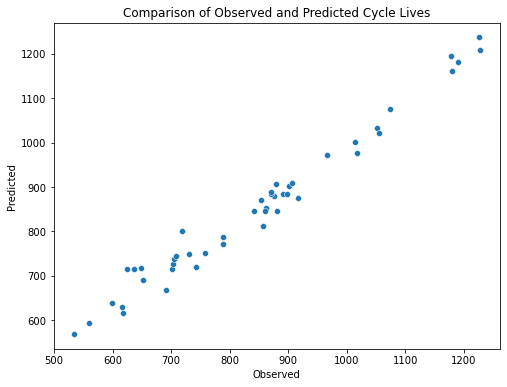

In [51]:
plt.figure(figsize=(8,6))
sns.scatterplot(observed, predicted)
plt.title("Comparison of Observed and Predicted Cycle Lives")
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.show()

A MAPE of ~5% is amazing to see, but it is important to be cautious for overfitting. However, the decision to use cycle data instead of summary data has proven successful. In a failed model, the best MAPE I was able to achieve was 26% with summary data. We can check to see how strongly we are overfit and then improve the model.

Our scatterplot reflects this strong accuracy, as the predicted cycle life accurately follows the observed cycle life.

## Testing on Batch 2<a class="anchor" id="chapter3"></a>

We move onto testing our model with a second batch. This will allow us to further tune our model and ensures that prediction results are not from the model memorizing cycle results.

In [52]:
batch_2 = pd.read_pickle('data/batch2.pkl')

In [53]:
b2_df = pd.DataFrame(batch_2)

In [54]:
b2_df

,b2c0,b2c1,b2c2,b2c3,b2c4,b2c5,b2c6,b2c7,b2c8,b2c9,...,b2c38,b2c39,b2c40,b2c41,b2c42,b2c43,b2c44,b2c45,b2c46,b2c47
cycle_life,[[300.0]],[[148.0]],[[438.0]],[[335.0]],[[444.0]],[[480.0]],[[511.0]],[[663.0]],[[982.0]],[[1061.0]],...,[[465.0]],[[459.0]],[[499.0]],[[429.0]],[[466.0]],[[462.0]],[[457.0]],[[487.0]],[[429.0]],[[713.0]]
charge_policy,1C(4%)-6C,2C(10%)-6C,2C(2%)-5C,2C(7%)-5.5C,3.6C(22%)-5.5C,3.6C(2%)-4.85C,3.6C(30%)-6C,80%)-3.6C,80%)-3.6C,80%)-3.6C,...,5.6C(47%)-4C,5.6C(58%)-3.5C,5.6C(5%)-4.75C,5.6C(65%)-3C,6C(20%)-4.5C,6C(31%)-4.25C,6C(40%)-4C,6C(4%)-4.75C,6C(52%)-3.5C,6C(60%)-3C
summary,"{'IR': [0.017542101, 0.017505454, 0.017570902,...","{'IR': [0.017852232, 0.017582141, 0.018061424,...","{'IR': [0.017804198, 0.017894397, 0.017902471,...","{'IR': [0.017053859, 0.016825944, 0.016992988,...","{'IR': [0.017030258, 0.016936054, 0.016789593,...","{'IR': [0.017228829, 0.017180175, 0.01708005, ...","{'IR': [0.017036749, 0.016829265, 0.016633883,...","{'IR': [0.017099461, 0.016932283, 0.017012727,...","{'IR': [0.017235447, 0.017149957, 0.017411867,...","{'IR': [0.017040562, 0.01676682, 0.017234532, ...",...,"{'IR': [0.017908165, 0.017847016, 0.017769802,...","{'IR': [0.018178858, 0.018174672, 0.018061638,...","{'IR': [0.017504752, 0.017582053, 0.017494036,...","{'IR': [0.017931128, 0.0179385, 0.017922211, 0...","{'IR': [0.017401671, 0.017394457, 0.017247235,...","{'IR': [0.018279195, 0.01812768, 0.018153407, ...","{'IR': [0.017798344, 0.01761589, 0.017666645, ...","{'IR': [0.017350584, 0.017153347, 0.017201968,...","{'IR': [0.017926272, 0.017752018, 0.017708456,...","{'IR': [0.017933726, 0.017923383, 0.017898172,..."
cycles,"{'0': {'I': [0.0, 0.15983060909090907, 0.24964...","{'0': {'I': [0.0, 0.2200386727272727, 0.359885...","{'0': {'I': [0.0, 0.23980574545454544, 0.37949...","{'0': {'I': [0.0, 0.19963350909090907, 0.33992...","{'0': {'I': [0.0, 0.3238305181818181, 0.467627...","{'0': {'I': [0.0, 0.32376202727272724, 0.50394...","{'0': {'I': [0.0, 0.2878613909090909, 0.503755...","{'0': {'I': [0.0, 0.21592573636363635, 0.39609...","{'0': {'I': [0.0, 0.17961501818181816, 0.17961...","{'0': {'I': [0.0, 0.2155434, 0.395916154545454...",...,"{'0': {'I': [0.0, 0.3354887545454545, 0.504445...","{'0': {'I': [0.0, 0.49707932727272724, 0.66572...","{'0': {'I': [0.0, 0.3923832272727273, 0.673072...","{'0': {'I': [0.0, 0.31128623636363634, 0.55942...","{'0': {'I': [0.0, 0.30023401818181816, 0.47515...","{'0': {'I': [0.0, 0.4190895818181818, 0.661905...","{'0': {'I': [0.0, 0.2987046636363636, 0.599566...","{'0': {'I': [0.0, 0.3656976909090909, 0.548508...","{'0': {'I': [0.0, 0.29520554545454547, 0.53541...","{'0': {'I': [0.0, 0.35800239999999994, 0.60128..."


### Accuracy Tests<a class="anchor" id="section3_1"></a>

Since we optimized for predictiion within a batch, our accuracy score for a separate batch; the accuracy score for this batch will naturally be poor. I expect the predictions to be the same.

This is why Batch 2 is used as a first test set, and Batch 3 is used as a second test set. We can change our modeling approach to fit Batch 2 better and consequently create a more robust model.

In [55]:
test_batch_dict = {'I':[], 'Qc':[], 'Qd':[], 'Qdlin':[], 'T':[], 'Tdlin':[], 'V':[], 'dQdV':[], 't':[], 'cycles_to_end':[]}

for cell in b2_df:
    for cycle in b2_df[cell]['cycles']:
        if cycle == '0':
            pass
        else:
            for feature in b2_df[cell]['cycles'][cycle]:
                test_batch_dict[feature].append((b2_df[cell]['cycles'][cycle][feature]).mean())
            test_batch_dict['cycles_to_end'].append(b2_df[cell]['cycle_life'][0][0] - int(cycle))

In [56]:
test_batch_df = pd.DataFrame(test_batch_dict)

In [57]:
test_batch_df

,I,Qc,Qd,Qdlin,T,Tdlin,V,dQdV,t,cycles_to_end
0,0.077386,0.875051,0.310851,0.735213,29.160560,28.742795,3.117573,-0.736326,28.558194,299.0
1,0.216487,0.868919,0.306553,0.745752,29.711384,30.455598,3.131849,-0.744661,28.102948,298.0
2,0.154922,0.874699,0.316756,0.748776,30.235232,30.513138,3.114318,-0.738428,28.531793,297.0
3,0.141742,0.873820,0.310136,0.739666,29.481769,29.804897,3.122827,-0.734238,28.420797,296.0
4,0.196484,0.872690,0.315840,0.746078,30.155729,30.781054,3.119352,-0.737051,28.463286,295.0
...,...,...,...,...,...,...,...,...,...,...
24867,1.600860,0.611512,0.173776,0.483222,33.351623,33.888963,3.246230,-0.530267,18.598232,-27.0
24868,1.822180,0.586992,0.161980,0.481914,33.224035,34.031335,3.266967,-0.536417,17.307106,-28.0
24869,1.649392,0.605834,0.171198,0.479582,33.282337,34.002001,3.252059,-0.537006,18.874456,-29.0
24870,1.424510,0.625689,0.179546,0.476974,33.373176,33.932254,3.236736,-0.529289,19.727472,-30.0


In [58]:
X = test_batch_df.drop(['cycles_to_end'], axis=1)
y = test_batch_df['cycles_to_end']

In [59]:
fitted_grid_batch.score(X, y)

-0.11330297770255049

While our previous model was very well fitted to Batch 1 (which has a wide distribution of cycle lives), it is not generalized enough for Batch 2 (which has a majority of cycle lives between 400 and 600). These distributions can be seen in `EDA.ipynb`.

Hopefully with our some model changes, we can get decent Batch 2 scores without losing too much of our 5% MAPE start.

Importantly, this does show that hyperparameter optimization in this problem space is fairly different from the classroom. Our model was optimized to 85% accuracy score for Batch 1. But that optimization leaves us with a model that performs extremely poorly.

We will still use GridSearch from now and look for the best accuracy score possible, but we will not prioritize large overall accuracy score; as that guarantees overfit across batches.

#### Accuracy and Prediction on Batch 2 Cell 7<a class="anchor" id="section3_1_1"></a>

In [60]:
test_dict = {'I':[], 'Qc':[], 'Qd':[], 'Qdlin':[], 'T':[], 'Tdlin':[], 'V':[], 'dQdV':[], 't':[], 'cycles_to_end':[]}
test_battery = 'b2c7'

cycle = 0

while cycle < 100:
    if cycle == 0:
        pass
    else:
        for feature in b2_df[test_battery]['cycles'][str(cycle)]:
            test_dict[feature].append((b2_df[test_battery]['cycles'][str(cycle)][feature]).mean())
        test_dict['cycles_to_end'].append(b2_df[test_battery]['cycle_life'][0][0] - int(cycle))
    cycle += 1

In [61]:
test_df = pd.DataFrame(test_dict)

In [62]:
# Check
test_df

,I,Qc,Qd,Qdlin,T,Tdlin,V,dQdV,t,cycles_to_end
0,-0.131612,0.802326,0.254793,0.703818,32.375651,33.919740,3.140087,-0.695303,25.453104,662.0
1,-0.164546,0.793913,0.268070,0.698264,32.063905,32.552640,3.117143,-0.704400,24.038117,661.0
2,-0.108114,0.799413,0.263292,0.701877,31.434766,33.240723,3.127689,-0.699291,25.378373,660.0
3,-0.045465,0.795357,0.252361,0.705814,32.386926,33.930057,3.140742,-0.702792,24.575388,659.0
4,-0.132998,0.798057,0.263915,0.708648,32.768985,34.068424,3.125987,-0.700454,24.405135,658.0
...,...,...,...,...,...,...,...,...,...,...
94,-0.163427,0.790381,0.268009,0.680140,31.112772,32.371884,3.105766,-0.679412,24.154767,568.0
95,-0.089162,0.785993,0.259887,0.687865,31.606991,33.158553,3.122156,-0.686608,24.117573,567.0
96,-0.143800,0.783183,0.269377,0.685438,32.179867,33.563756,3.108746,-0.687910,24.378345,566.0
97,-0.064800,0.776671,0.263319,0.677362,31.512140,31.767202,3.110581,-0.681768,23.527255,565.0


In [63]:
X = test_df.drop('cycles_to_end', axis=1)
y = test_df['cycles_to_end']

In [64]:
fitted_grid_batch.predict(X)

array([217.42,  65.94, 199.94, 230.22, 239.6 , 197.84, 130.2 , 250.4 ,
       147.58, 123.06, 145.52,  49.7 , 190.92, 118.96, 228.18, 106.48,
       118.22, 242.28,  82.66,  87.16, 201.66,  64.92, 218.42,  69.7 ,
       105.58, 117.72,  54.44,  80.54,  67.3 , 189.56,  70.74,  37.66,
       170.5 , 175.06,  42.76,  73.42, 224.06,  63.96,  35.74, 194.42,
        40.34,  71.2 , 122.56,  64.78, 169.98,  49.18, 162.72,  36.28,
        53.24,  98.4 ,  62.48, 153.34,  56.32, 177.92, 153.48, 209.72,
       150.02,  54.66,  62.2 ,  60.94, 173.08,  22.36, 109.5 , 161.6 ,
        53.9 , 205.74,  32.44,  75.1 , 204.04, 213.98, 120.1 ,  66.6 ,
       206.08, 143.6 ,  49.6 ,  33.62, 187.78, 140.22,  20.92,  52.76,
       144.34,  45.98, 148.78,  61.  , 162.6 ,  24.86, 174.92, 126.46,
        52.8 ,  55.  ,  63.6 , 169.38,  26.26,  68.2 , 120.7 , 182.76,
        14.32, 141.5 , 150.3 ])

In [65]:
b2_df[test_battery]['cycle_life'][0][0]

663.0

In [66]:
100 + 150.3

250.3

Test error of ~65%

#### Accuracy and Prediction on Batch 2 Cell 9<a class="anchor" id="section3_1_2"></a>

In [67]:
test_dict = {'I':[], 'Qc':[], 'Qd':[], 'Qdlin':[], 'T':[], 'Tdlin':[], 'V':[], 'dQdV':[], 't':[], 'cycles_to_end':[]}
test_battery = 'b2c9'

cycle = 0

while cycle < 100:
    if cycle == 0:
        pass
    else:
        for feature in b2_df[test_battery]['cycles'][str(cycle)]:
            test_dict[feature].append((b2_df[test_battery]['cycles'][str(cycle)][feature]).mean())
        test_dict['cycles_to_end'].append(b2_df[test_battery]['cycle_life'][0][0] - int(cycle))
    cycle += 1

In [68]:
test_df = pd.DataFrame(test_dict)

In [69]:
X = test_df.drop('cycles_to_end', axis=1)
y = test_df['cycles_to_end']

In [70]:
fitted_grid_batch.predict(X)

array([276.64, 229.56, 333.94, 335.36,  96.56, 333.52, 395.64, 277.72,
       411.24, 334.94, 274.98, 325.04, 342.94, 274.24, 377.34, 328.68,
       373.76, 109.44, 329.34, 243.88, 126.58, 327.48, 198.2 , 260.54,
       238.5 , 378.22, 234.58, 184.98, 168.14, 232.56,  96.12, 115.02,
       205.5 , 227.72, 228.44, 378.2 , 263.8 , 234.46, 337.12, 254.14,
       256.38, 349.68, 331.38, 259.46, 209.56, 268.64, 229.88, 193.92,
       354.44, 329.92, 217.3 , 235.1 , 246.62, 254.52, 126.06, 253.08,
       325.3 , 209.58,  91.04, 211.26, 121.6 , 298.44, 399.96, 259.84,
       292.98, 235.02, 338.56, 204.9 , 332.94, 358.98, 245.4 , 217.58,
       242.52, 205.58, 217.16, 253.2 , 365.2 , 181.16, 275.42, 244.1 ,
       157.16, 216.06, 244.86, 240.64, 137.22, 156.8 , 117.98, 110.12,
       265.46, 265.48, 250.54, 142.16, 213.66, 117.58, 227.22, 238.7 ,
       262.64, 218.74, 279.78])

In [71]:
b2_df[test_battery]['cycle_life'][0][0]

1061.0

In [72]:
100 + 279.78

379.78

Test error of ~64%.

Both example predictions were very poor. Our current model is flawed, and I expect the MAPE to show similar results.

### MAPE on Batch 2<a class="anchor" id="section3_2"></a>

In [73]:
cell_errors = []

for cell in b2_df:
    test_dict = {'I':[], 'Qc':[], 'Qd':[], 'Qdlin':[], 'T':[], 'Tdlin':[], 'V':[], 'dQdV':[], 't':[], 'cycles_to_end':[]}
    test_battery = cell
    
    cycle = 0
    
    # We pass over cell b2c1 as the Stanford Researchers did. The outlier has a cycle life of 148
    # possible due to data collection errors, so we do not use it in MAPE calculation
    if cell == 'b2c1':
        pass
    else:
        while cycle < 100:
            if cycle == 0:
                pass
            else:
                for feature in b2_df[test_battery]['cycles'][str(cycle)]:
                    test_dict[feature].append((b2_df[test_battery]['cycles'][str(cycle)][feature]).mean())
                test_dict['cycles_to_end'].append(b2_df[test_battery]['cycle_life'][0][0] - int(cycle))
            cycle += 1

        test_df = pd.DataFrame(test_dict)

        X = test_df.drop('cycles_to_end', axis=1)
        y = test_df['cycles_to_end']

        cell_errors.append([abs(fitted_grid_batch.predict(X)[98] + 100 - b2_df[test_battery]['cycle_life'][0][0])*100.0/
                                b2_df[test_battery]['cycle_life'][0][0], b2_df[test_battery]['cycle_life'][0][0],
                        fitted_grid_batch.predict(X)[98] + 100])

In [74]:
error_sum = 0
for i in cell_errors:
    error_sum += i[0]
print(error_sum/len(cell_errors))

38.90438527968473


In [75]:
cell_errors.sort(key=lambda x: x[0])

In [76]:
cell_errors

[[2.8026030368763593, 461.0, 448.08],
 [8.872798434442254, 511.0, 556.3399999999999],
 [13.942505133470222, 487.0, 554.9],
 [15.607843137254893, 561.0, 648.56],
 [16.660287081339707, 209.0, 174.18],
 [17.25616698292221, 527.0, 617.94],
 [21.377279102384303, 713.0, 560.5799999999999],
 [21.986899563318786, 458.0, 558.7],
 [24.593073593073594, 462.0, 575.62],
 [25.879049676025904, 463.0, 582.8199999999999],
 [26.640000000000008, 300.0, 379.92],
 [29.573831775700942, 535.0, 693.22],
 [30.623655913978492, 465.0, 607.4],
 [31.450746268656722, 335.0, 440.36],
 [31.859956236323857, 457.0, 602.6],
 [32.34764826175868, 489.0, 647.18],
 [33.42967244701349, 519.0, 692.5],
 [34.46376811594204, 483.0, 649.46],
 [34.577154308617224, 499.0, 671.54],
 [34.75416666666668, 480.0, 646.82],
 [35.621621621621635, 444.0, 602.1600000000001],
 [36.59869848156183, 461.0, 629.72],
 [36.742138364779876, 477.0, 652.26],
 [37.26915520628685, 509.0, 698.7],
 [38.18376068376069, 468.0, 646.7],
 [40.558704453441294, 

In [77]:
observed = []
predicted = []
for prediction in cell_errors:
    observed.append(prediction[1])
    predicted.append(prediction[2])

C:\Users\miahn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


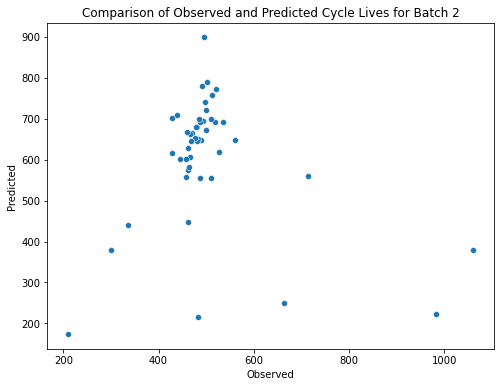

In [78]:
plt.figure(figsize=(8,6))
sns.scatterplot(observed, predicted)
plt.title("Comparison of Observed and Predicted Cycle Lives for Batch 2")
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.show()

With a final MAPE of ~39%, it is clear that our model is overfit and does not handle datasets with generally smaller cycle lives well. 

To be fair, Batch 1 has no batteries with cycles lives below 500, which is mainly the case here. The model we choose should be generalized well to get the MAPE down a little bit at least, though it may be difficult to control for the model intercept.

Our training data is normalized higher, and will naturally have a higher intercept, we should try counteract this effect.

## Model Improvement<a class="anchor" id="chapter4"></a>

Our next approach is ElasticNet, which is the training model that the Stanford researchers used. This will introduce regularization and give us the ability to change the intercept attributes. However, we will first ensure that our MAPE for Batch 1 is acceptable before using the model on Batch 2.

In [79]:
from sklearn.linear_model import ElasticNet

In [80]:
X = batch_df.drop(['cycles_to_end'], axis=1)
y = batch_df['cycles_to_end']

The hyperparameters we will be optimizing for are alpha, l1_ratio, and fit_intercept.

`alpha` is a multiplier on the penalty term for feature coefficients. A higher alpha reduces the size of the coefficients.

`l1_ratio` reflects the model's likeness to either L2 regularization or L1 regularization. A l1_ratio of 0 is the L2 penalty while a l1_ratio of 1 is the L1 penalty. You can select floats between 0 and 1 for a combination of the two.

Lastly is `fit_intercept`. A fit_intercept=True will have the model estimate the intercept. Otherwise, it will not and assume that the data is already centered. Testing this, I hope to see if we can optimize for the high intercept in Batch 1 with stronger coefficients.

In [81]:
# Student Note: Again, I cut out some of the parameter grid to make the
# GridSearch quicker to run. Higher alphas and l1_ratios are preferred
# so I will not be using them in this cell
estimators = [('scaler',StandardScaler()),('model',ElasticNet())]

mypipe = Pipeline(estimators)

param_grid = [{'model':[ElasticNet()],
             'model__alpha':[5, 10, 25, 50],
            'model__l1_ratio':[.5, .75, 1],
            'model__fit_intercept':[True, False]}
             ]

grid = GridSearchCV(mypipe,param_grid,cv = 5)

fitted_grid_batch = grid.fit(X,y)

fitted_grid_batch.best_score_

0.5907198408490224

In [82]:
pd.DataFrame(fitted_grid_batch.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__alpha,param_model__fit_intercept,param_model__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,0.025128,0.002722,0.003387,0.000794,"ElasticNet(alpha=10, l1_ratio=1)",10,True,1,"{'model': ElasticNet(alpha=10, l1_ratio=1), 'm...",0.383206,0.727852,0.725080,0.802716,0.314745,0.590720,0.200512,1
14,0.021766,0.003646,0.002782,0.000744,"ElasticNet(alpha=10, l1_ratio=1)",25,True,1,"{'model': ElasticNet(alpha=10, l1_ratio=1), 'm...",0.350961,0.699430,0.728929,0.812805,0.332151,0.584855,0.202194,2
2,0.023936,0.004462,0.003390,0.001491,"ElasticNet(alpha=10, l1_ratio=1)",5,True,1,"{'model': ElasticNet(alpha=10, l1_ratio=1), 'm...",0.377021,0.735770,0.715928,0.795481,0.220615,0.568963,0.227562,3
20,0.022332,0.004479,0.002594,0.000797,"ElasticNet(alpha=10, l1_ratio=1)",50,True,1,"{'model': ElasticNet(alpha=10, l1_ratio=1), 'm...",0.262500,0.646212,0.700180,0.794759,0.380255,0.556781,0.201473,4
1,0.024543,0.004225,0.003980,0.000017,"ElasticNet(alpha=10, l1_ratio=1)",5,True,0.75,"{'model': ElasticNet(alpha=10, l1_ratio=1), 'm...",0.188554,0.562408,0.167772,0.711701,0.560001,0.438087,0.219326,5
7,0.021547,0.001619,0.003192,0.000747,"ElasticNet(alpha=10, l1_ratio=1)",10,True,0.75,"{'model': ElasticNet(alpha=10, l1_ratio=1), 'm...",0.089394,0.447310,0.266580,0.585780,0.457332,0.369279,0.172973,6
0,0.026752,0.009279,0.002990,0.001095,"ElasticNet(alpha=10, l1_ratio=1)",5,True,0.5,"{'model': ElasticNet(alpha=10, l1_ratio=1), 'm...",0.100115,0.457418,0.167543,0.598949,0.468040,0.358413,0.191221,7
6,0.020545,0.003373,0.003495,0.000888,"ElasticNet(alpha=10, l1_ratio=1)",10,True,0.5,"{'model': ElasticNet(alpha=10, l1_ratio=1), 'm...",-0.002083,0.324569,0.246126,0.428463,0.312478,0.261910,0.144336,8
13,0.022744,0.004783,0.002792,0.000976,"ElasticNet(alpha=10, l1_ratio=1)",25,True,0.75,"{'model': ElasticNet(alpha=10, l1_ratio=1), 'm...",-0.051281,0.262227,0.293394,0.340590,0.230799,0.215146,0.138061,9
12,0.018575,0.002402,0.003795,0.000743,"ElasticNet(alpha=10, l1_ratio=1)",25,True,0.5,"{'model': ElasticNet(alpha=10, l1_ratio=1), 'm...",-0.113850,0.166641,0.201780,0.204386,0.097713,0.111334,0.118989,10


While the accuracy on Batch 1 suffers greatly, we will check the MAPE first and some predictions for both Batch 1 and 2. ElasticNet scores also seem to prefer a `l1_ratio` of 1, meaning it behaves more like L1 regularization. Unfortunately, it also unanimously prefers a `fit_intercept` of True, meaning the intercept behavior will remain unchanged.

### MAPE Predictions<a class="anchor" id="section4_1"></a>

__Batch 1__

In [83]:
cell_errors = []

for cell in b1_df:
    test_dict = {'I':[], 'Qc':[], 'Qd':[], 'Qdlin':[], 'T':[], 'Tdlin':[], 'V':[], 'dQdV':[], 't':[], 'cycles_to_end':[]}
    test_battery = cell
    
    cycle = 0
    
    while cycle < 100:
        if cycle == 0:
            pass
        else:
            for feature in b1_df[test_battery]['cycles'][str(cycle)]:
                test_dict[feature].append((b1_df[test_battery]['cycles'][str(cycle)][feature]).mean())
            test_dict['cycles_to_end'].append(b1_df[test_battery]['cycle_life'][0][0] - int(cycle))
        cycle += 1

    test_df = pd.DataFrame(test_dict)

    X = test_df.drop('cycles_to_end', axis=1)
    y = test_df['cycles_to_end']

    cell_errors.append([abs(fitted_grid_batch.predict(X)[98] + 100 - b1_df[test_battery]['cycle_life'][0][0])*100.0/
                            b1_df[test_battery]['cycle_life'][0][0], b1_df[test_battery]['cycle_life'][0][0]])

In [84]:
error_sum = 0
for i in cell_errors:
    error_sum += i[0]
print(error_sum/len(cell_errors))

17.004505982030565


In [85]:
cell_errors.sort(key=lambda x: x[0])

In [86]:
cell_errors

[[0.39939839537591515, 704.0],
 [1.394461246802806, 651.0],
 [3.111153004539481, 719.0],
 [3.651130019474511, 709.0],
 [4.356028017210899, 702.0],
 [4.409994262336205, 757.0],
 [4.476725014552297, 691.0],
 [4.484029440395695, 648.0],
 [8.697445065791028, 731.0],
 [8.85258813484639, 870.0],
 [9.463594172242006, 876.0],
 [9.857756166039703, 599.0],
 [9.925021761175703, 742.0],
 [10.089454028557054, 703.0],
 [11.185378991612927, 788.0],
 [11.728852758772897, 862.0],
 [12.246641357678923, 879.0],
 [12.396312186312372, 788.0],
 [13.199297690460526, 617.0],
 [13.504352879747357, 870.0],
 [17.254708279066545, 842.0],
 [17.672497051006918, 897.0],
 [17.704991842792623, 636.0],
 [17.899071684739106, 857.0],
 [18.49054799167919, 906.0],
 [18.553250281038455, 854.0],
 [19.0275238279248, 966.0],
 [20.17020158806796, 880.0],
 [20.4186888493741, 891.0],
 [20.68187344568609, 860.0],
 [21.224629890064065, 559.0],
 [21.724189768527292, 534.0],
 [22.125026265356084, 917.0],
 [22.308904341622476, 902.0],

While disappointingly, our model does not maintain the 5% MAPE from BaggingRegressor, that is expected. Howeverm ElasticNet should be better fit for Batch 2 which was the goal.

__Batch 2__

In [87]:
cell_errors = []

for cell in b2_df:
    test_dict = {'I':[], 'Qc':[], 'Qd':[], 'Qdlin':[], 'T':[], 'Tdlin':[], 'V':[], 'dQdV':[], 't':[], 'cycles_to_end':[]}
    test_battery = cell
    
    cycle = 0
    
    if cell == 'b2c1':
        pass
    else:
        while cycle < 100:
            if cycle == 0:
                pass
            else:
                for feature in b2_df[test_battery]['cycles'][str(cycle)]:
                    test_dict[feature].append((b2_df[test_battery]['cycles'][str(cycle)][feature]).mean())
                test_dict['cycles_to_end'].append(b2_df[test_battery]['cycle_life'][0][0] - int(cycle))
            cycle += 1

        test_df = pd.DataFrame(test_dict)

        X = test_df.drop('cycles_to_end', axis=1)
        y = test_df['cycles_to_end']

        cell_errors.append([abs(fitted_grid_batch.predict(X)[98] + 100 - b2_df[test_battery]['cycle_life'][0][0])*100.0/
                                b2_df[test_battery]['cycle_life'][0][0], b2_df[test_battery]['cycle_life'][0][0]])

In [88]:
error_sum = 0
for i in cell_errors:
    error_sum += i[0]
print(error_sum/len(cell_errors))

36.379616754672774


In [89]:
cell_errors.sort(key=lambda x: x[0])

In [90]:
cell_errors

[[1.9287296025683958, 461.0],
 [2.3099436187612246, 483.0],
 [2.7906527191217716, 511.0],
 [14.068175754936682, 527.0],
 [15.060784896868466, 713.0],
 [15.556490569274109, 487.0],
 [15.573214078259186, 335.0],
 [16.425828957067775, 483.0],
 [18.075537899101892, 209.0],
 [19.4583148607836, 663.0],
 [21.56044365532258, 458.0],
 [25.105248057964666, 535.0],
 [29.7295416468158, 499.0],
 [32.13559084292998, 462.0],
 [32.14014192665001, 509.0],
 [32.2726800455763, 519.0],
 [33.52047155581048, 561.0],
 [34.41008373863181, 498.0],
 [34.60181645896866, 477.0],
 [35.08731428672801, 520.0],
 [35.73494445778896, 444.0],
 [36.06380906761384, 463.0],
 [37.342044137343436, 982.0],
 [38.11359784046709, 478.0],
 [39.226847346826226, 481.0],
 [39.254230431597435, 465.0],
 [39.60917169529171, 502.0],
 [39.634187995239216, 1061.0],
 [39.86961010707346, 489.0],
 [41.226285779208936, 513.0],
 [41.96952512435266, 457.0],
 [44.69154298590916, 459.0],
 [45.01231853038847, 429.0],
 [46.81492806356328, 492.0],
 

While our MAPE for Batch 1 increased by 12%, our MAPE for Batch 2 only went down 2.5%. ElasticNet lost greatly in score, but is showing better fit. We will perform further improvements, including implementing PCA. I am hoping that capturing most of the variance and feature reduction will help generalize the model more.

### Model Improvement II<a class="anchor" id="section4_2"></a>

The hyperparameter we are optimizing for at this stage is `n_components`. I am curious what percent of variance to capture for the best results on Batch 1, and how that translates to results on Batch 2.

In [91]:
from sklearn.decomposition import PCA

In [92]:
X = batch_df.drop(['cycles_to_end'], axis=1)
y = batch_df['cycles_to_end']

In [93]:
estimators = [('scaler',StandardScaler()), ('pca', PCA()), ('model',ElasticNet())]

mypipe = Pipeline(estimators)

param_grid = [{'model':[ElasticNet()],
             'model__alpha':[5, 10, 25, 50],
            'model__l1_ratio':[.5, .75, 1],
            'model__fit_intercept':[True],
            'pca__n_components':[.75, .90, .95]}
             ]

grid = GridSearchCV(mypipe,param_grid,cv = 5)

fitted_grid_batch = grid.fit(X,y)

fitted_grid_batch.best_score_

0.4305084687335386

In [94]:
pd.DataFrame(fitted_grid_batch.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__alpha,param_model__fit_intercept,param_model__l1_ratio,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,0.028125,0.002917,0.003191,0.000746,"ElasticNet(alpha=5, l1_ratio=1)",5,True,1,0.95,"{'model': ElasticNet(alpha=5, l1_ratio=1), 'mo...",0.361470,0.723166,-0.367752,0.779616,0.656041,0.430508,0.424353,1
7,0.031318,0.005261,0.002991,0.000890,"ElasticNet(alpha=5, l1_ratio=1)",5,True,1,0.9,"{'model': ElasticNet(alpha=5, l1_ratio=1), 'mo...",0.306800,0.677174,-0.367752,0.760459,0.656041,0.406544,0.417188,2
17,0.033909,0.003937,0.003591,0.001017,"ElasticNet(alpha=5, l1_ratio=1)",10,True,1,0.95,"{'model': ElasticNet(alpha=5, l1_ratio=1), 'mo...",0.338809,0.712055,-0.636967,0.782872,0.657977,0.370949,0.526374,3
6,0.025733,0.005329,0.003789,0.001165,"ElasticNet(alpha=5, l1_ratio=1)",5,True,1,0.75,"{'model': ElasticNet(alpha=5, l1_ratio=1), 'mo...",0.245526,0.658468,-0.476480,0.734097,0.655406,0.363403,0.453661,4
5,0.030121,0.004250,0.003989,0.000893,"ElasticNet(alpha=5, l1_ratio=1)",5,True,0.75,0.95,"{'model': ElasticNet(alpha=5, l1_ratio=1), 'mo...",0.182949,0.563504,-0.233450,0.710145,0.577627,0.360155,0.344936,5
4,0.028128,0.005578,0.003989,0.001261,"ElasticNet(alpha=5, l1_ratio=1)",5,True,0.75,0.9,"{'model': ElasticNet(alpha=5, l1_ratio=1), 'mo...",0.180893,0.552500,-0.236474,0.692644,0.577627,0.353438,0.341384,6
16,0.023936,0.003025,0.002993,0.000631,"ElasticNet(alpha=5, l1_ratio=1)",10,True,1,0.9,"{'model': ElasticNet(alpha=5, l1_ratio=1), 'mo...",0.306821,0.673262,-0.636967,0.762159,0.657977,0.352651,0.518682,7
15,0.024935,0.003784,0.003691,0.001162,"ElasticNet(alpha=5, l1_ratio=1)",10,True,1,0.75,"{'model': ElasticNet(alpha=5, l1_ratio=1), 'mo...",0.232002,0.655615,-0.636967,0.739534,0.657906,0.329618,0.514955,8
2,0.025931,0.002676,0.003392,0.001197,"ElasticNet(alpha=5, l1_ratio=1)",5,True,0.5,0.95,"{'model': ElasticNet(alpha=5, l1_ratio=1), 'mo...",0.094627,0.459119,0.019763,0.599437,0.473207,0.329230,0.228657,9
1,0.029322,0.004617,0.003391,0.001017,"ElasticNet(alpha=5, l1_ratio=1)",5,True,0.5,0.9,"{'model': ElasticNet(alpha=5, l1_ratio=1), 'mo...",0.094605,0.452297,0.015486,0.585868,0.473207,0.324293,0.225876,10


While the accuracy on Batch 1 is further reduced, we know that accuracy does not translate to MAPE; so we check those first.

### MAPE Predictions II<a class="anchor" id="section4_3"></a>

__Batch 1__

In [95]:
cell_errors = []

for cell in b1_df:
    test_dict = {'I':[], 'Qc':[], 'Qd':[], 'Qdlin':[], 'T':[], 'Tdlin':[], 'V':[], 'dQdV':[], 't':[], 'cycles_to_end':[]}
    test_battery = cell
    
    cycle = 0
    
    while cycle < 100:
        if cycle == 0:
            pass
        else:
            for feature in b1_df[test_battery]['cycles'][str(cycle)]:
                test_dict[feature].append((b1_df[test_battery]['cycles'][str(cycle)][feature]).mean())
            test_dict['cycles_to_end'].append(b1_df[test_battery]['cycle_life'][0][0] - int(cycle))
        cycle += 1

    test_df = pd.DataFrame(test_dict)

    X = test_df.drop('cycles_to_end', axis=1)
    y = test_df['cycles_to_end']

    cell_errors.append([abs(fitted_grid_batch.predict(X)[98] + 100 - b1_df[test_battery]['cycle_life'][0][0])*100.0/
                            b1_df[test_battery]['cycle_life'][0][0], b1_df[test_battery]['cycle_life'][0][0]])

In [96]:
error_sum = 0
for i in cell_errors:
    error_sum += i[0]
print(error_sum/len(cell_errors))

16.902350981641597


In [97]:
cell_errors.sort(key=lambda x: x[0])

In [98]:
cell_errors

[[1.0799020966763757, 651.0],
 [1.9458785941502783, 691.0],
 [2.21215074042094, 702.0],
 [2.261895178152494, 719.0],
 [2.599098400549957, 709.0],
 [2.8235030919782385, 757.0],
 [2.916606577621634, 704.0],
 [5.6030226311182885, 648.0],
 [5.65044376834311, 731.0],
 [7.19589207967375, 703.0],
 [7.446758589280919, 742.0],
 [7.902181349865548, 876.0],
 [9.729792320548109, 870.0],
 [10.925891973370073, 788.0],
 [10.98877793261983, 617.0],
 [11.062115046402507, 862.0],
 [11.539459411981582, 879.0],
 [11.853083587253503, 788.0],
 [13.106832738591184, 599.0],
 [13.523322661759611, 870.0],
 [15.55510885780283, 636.0],
 [15.81817343256774, 897.0],
 [16.049609416056605, 857.0],
 [17.579430596895953, 842.0],
 [18.773981187123614, 906.0],
 [19.01441626287555, 854.0],
 [20.010156843224483, 880.0],
 [20.334762509943268, 891.0],
 [20.48067066746053, 917.0],
 [20.930880021234696, 860.0],
 [22.29433190217824, 902.0],
 [23.006739426999395, 966.0],
 [23.35288335557446, 616.0],
 [23.43387088866966, 534.0],


While accuracy did decrease with PCA, our MAPE stayed roughly the same/ reduced insignificanlty.

__Batch 2__

In [99]:
cell_errors = []

for cell in b2_df:
    test_dict = {'I':[], 'Qc':[], 'Qd':[], 'Qdlin':[], 'T':[], 'Tdlin':[], 'V':[], 'dQdV':[], 't':[], 'cycles_to_end':[]}
    test_battery = cell
    
    cycle = 0
    
    if cell == 'b2c1':
        pass
    else:
        while cycle < 100:
            if cycle == 0:
                pass
            else:
                for feature in b2_df[test_battery]['cycles'][str(cycle)]:
                    test_dict[feature].append((b2_df[test_battery]['cycles'][str(cycle)][feature]).mean())
                test_dict['cycles_to_end'].append(b2_df[test_battery]['cycle_life'][0][0] - int(cycle))
            cycle += 1

        test_df = pd.DataFrame(test_dict)

        X = test_df.drop('cycles_to_end', axis=1)
        y = test_df['cycles_to_end']

        cell_errors.append([abs(fitted_grid_batch.predict(X)[98] + 100 - b2_df[test_battery]['cycle_life'][0][0])*100.0/
                                b2_df[test_battery]['cycle_life'][0][0], b2_df[test_battery]['cycle_life'][0][0]])

In [100]:
error_sum = 0
for i in cell_errors:
    error_sum += i[0]
print(error_sum/len(cell_errors))

34.8005597724626


In [101]:
cell_errors.sort(key=lambda x: x[0])

In [102]:
cell_errors

[[2.782758450601111, 461.0],
 [3.9081053477517385, 483.0],
 [4.372314190199416, 429.0],
 [10.172229895801863, 209.0],
 [13.67923406183105, 457.0],
 [14.01427989795692, 487.0],
 [15.146024025168138, 462.0],
 [15.694735791600687, 527.0],
 [16.79876021285173, 511.0],
 [18.133766091139762, 483.0],
 [23.073939422751383, 458.0],
 [23.11593231400193, 663.0],
 [24.90815576967972, 535.0],
 [25.404142679048547, 466.0],
 [25.70727932827685, 713.0],
 [28.07253177989641, 335.0],
 [29.00919064758444, 561.0],
 [33.01528335819825, 499.0],
 [33.582943551996514, 498.0],
 [33.91622735592477, 509.0],
 [34.26872935481376, 477.0],
 [34.606699992007236, 519.0],
 [36.996770377922594, 520.0],
 [37.08870941433733, 444.0],
 [39.62300800761244, 429.0],
 [40.53135020459084, 481.0],
 [40.72095685432097, 502.0],
 [41.11400552126332, 982.0],
 [41.20952234507779, 478.0],
 [41.461124407276415, 489.0],
 [41.60484079131324, 463.0],
 [43.218288599946504, 1061.0],
 [43.8414183959187, 465.0],
 [44.20577809143989, 513.0],
 [

While both our Batch 1 and Batch 2 MAPE results have improved, the overfit does not seem to go down significantly. I had also hoped that `fit_intercept` set to `False` would improve our model performance on Batch 2, since the intercepts would be set high when trained on data with an average of 900 cycles. However, the model performed worse and returned worse MAPE with it set false, so we are stuck with high intercept.

Just for completeness, we will try optimize our previous BagRegressor model with PCA as well to see if we can improve fit without regularization, although I am not confident in probability of that result.

### Bagging Regressor with PCA<a class="anchor" id="section4_4"></a>

In [103]:
X = batch_df.drop(['cycles_to_end'], axis=1)
y = batch_df['cycles_to_end']

In [104]:
# Student Note: This is the second to last GridSearch
# Unfortunately, it does take longer than the previous ones,
# Please run it still
estimators = [('scaler',StandardScaler()), ('pca', PCA()), ('model',BaggingRegressor())]

mypipe = Pipeline(estimators)

param_grid = [{'model':[BaggingRegressor()],
             'model__max_samples':[.1,.25,.5],
            'model__n_estimators' :[10,25,50],
            'pca__n_components':[.90, .95]}]

grid = GridSearchCV(mypipe,param_grid,cv = 5)

fitted_grid_batch = grid.fit(X,y)

In [105]:
fitted_grid_batch.best_score_

0.7641787836483

In [106]:
pd.DataFrame(fitted_grid_batch.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__max_samples,param_model__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,1.141728,0.055276,0.072675,0.006832,"BaggingRegressor(max_samples=0.1, n_estimators...",0.1,50,0.9,"{'model': BaggingRegressor(max_samples=0.1, n_...",0.409012,0.897025,0.864397,0.924843,0.725618,0.764179,0.190334,1
0,0.280243,0.027185,0.015549,0.002233,"BaggingRegressor(max_samples=0.1, n_estimators...",0.1,10,0.9,"{'model': BaggingRegressor(max_samples=0.1, n_...",0.434788,0.888615,0.851916,0.929553,0.713317,0.763638,0.179786,2
5,1.267062,0.074107,0.073226,0.007338,"BaggingRegressor(max_samples=0.1, n_estimators...",0.1,50,0.95,"{'model': BaggingRegressor(max_samples=0.1, n_...",0.428140,0.897042,0.856125,0.914717,0.715121,0.762229,0.181151,3
3,0.664735,0.047667,0.040263,0.003408,"BaggingRegressor(max_samples=0.1, n_estimators...",0.1,25,0.95,"{'model': BaggingRegressor(max_samples=0.1, n_...",0.405933,0.895207,0.853212,0.930088,0.721840,0.761256,0.191160,4
11,3.278725,0.417109,0.092056,0.030786,"BaggingRegressor(max_samples=0.1, n_estimators...",0.25,50,0.95,"{'model': BaggingRegressor(max_samples=0.1, n_...",0.405001,0.895182,0.857446,0.927952,0.716115,0.760339,0.191795,5
10,2.751516,0.216465,0.084856,0.009132,"BaggingRegressor(max_samples=0.1, n_estimators...",0.25,50,0.9,"{'model': BaggingRegressor(max_samples=0.1, n_...",0.386795,0.892151,0.862434,0.919523,0.721629,0.756507,0.197027,6
2,0.603534,0.040493,0.037280,0.005508,"BaggingRegressor(max_samples=0.1, n_estimators...",0.1,25,0.9,"{'model': BaggingRegressor(max_samples=0.1, n_...",0.392945,0.890697,0.864606,0.919366,0.712482,0.756019,0.195105,7
15,3.035211,0.225350,0.052652,0.011988,"BaggingRegressor(max_samples=0.1, n_estimators...",0.5,25,0.95,"{'model': BaggingRegressor(max_samples=0.1, n_...",0.387129,0.886374,0.853761,0.919354,0.721625,0.753649,0.195171,8
9,1.603940,0.069488,0.042882,0.003026,"BaggingRegressor(max_samples=0.1, n_estimators...",0.25,25,0.95,"{'model': BaggingRegressor(max_samples=0.1, n_...",0.384633,0.890030,0.860340,0.892079,0.716372,0.748691,0.193176,9
14,2.616150,0.153276,0.044865,0.006709,"BaggingRegressor(max_samples=0.1, n_estimators...",0.5,25,0.9,"{'model': BaggingRegressor(max_samples=0.1, n_...",0.359915,0.887324,0.859372,0.904409,0.726486,0.747501,0.203642,10


Our score for BaggingRegressor is worse than without PCA, but that is promising for fit. We should see improvement with Batch 2 MAPE, but let's see if it beats ElasticNet.

__Batch 1__

In [107]:
cell_errors = []

for cell in b1_df:
    test_dict = {'I':[], 'Qc':[], 'Qd':[], 'Qdlin':[], 'T':[], 'Tdlin':[], 'V':[], 'dQdV':[], 't':[], 'cycles_to_end':[]}
    test_battery = cell
    
    cycle = 0
    
    while cycle < 100:
        if cycle == 0:
            pass
        else:
            for feature in b1_df[test_battery]['cycles'][str(cycle)]:
                test_dict[feature].append((b1_df[test_battery]['cycles'][str(cycle)][feature]).mean())
            test_dict['cycles_to_end'].append(b1_df[test_battery]['cycle_life'][0][0] - int(cycle))
        cycle += 1

    test_df = pd.DataFrame(test_dict)

    X = test_df.drop('cycles_to_end', axis=1)
    y = test_df['cycles_to_end']

    cell_errors.append([abs(fitted_grid_batch.predict(X)[98] + 100 - b1_df[test_battery]['cycle_life'][0][0])*100.0/
                            b1_df[test_battery]['cycle_life'][0][0], b1_df[test_battery]['cycle_life'][0][0]])

In [108]:
error_sum = 0
for i in cell_errors:
    error_sum += i[0]
print(error_sum/len(cell_errors))

6.828426150833115


In [109]:
cell_errors.sort(key=lambda x: x[0])

In [110]:
cell_errors

[[0.0673854447439353, 742.0],
 [0.2671232876712365, 876.0],
 [0.2884927066450523, 617.0],
 [0.30527497194164166, 891.0],
 [0.32714617169374133, 862.0],
 [0.5555555555555524, 702.0],
 [0.6894197952218368, 879.0],
 [0.7076350093109784, 1074.0],
 [1.1068883610451365, 842.0],
 [1.1172214182344469, 691.0],
 [1.2913907284768262, 906.0],
 [1.3813953488372088, 860.0],
 [1.649746192893401, 788.0],
 [1.8676844783714996, 1179.0],
 [3.190687361419066, 902.0],
 [3.2567287784679126, 966.0],
 [3.3218390804597675, 870.0],
 [3.472081218274113, 788.0],
 [3.6117455138662296, 1226.0],
 [4.076335877862595, 917.0],
 [4.65042016806722, 1190.0],
 [5.015647226173541, 703.0],
 [5.167816091954027, 870.0],
 [5.221850613154965, 897.0],
 [5.384090909090909, 880.0],
 [5.6533957845433225, 854.0],
 [5.916527545909859, 599.0],
 [6.0122887864823324, 651.0],
 [6.035859820700892, 1227.0],
 [6.2520420070011715, 857.0],
 [6.662337662337657, 616.0],
 [6.674596431605773, 1177.0],
 [7.549374130737131, 719.0],
 [7.8778409090909

__Batch 2__

In [111]:
cell_errors = []

for cell in b2_df:
    test_dict = {'I':[], 'Qc':[], 'Qd':[], 'Qdlin':[], 'T':[], 'Tdlin':[], 'V':[], 'dQdV':[], 't':[], 'cycles_to_end':[]}
    test_battery = cell
    
    cycle = 0
    
    if cell == 'b2c1':
        pass
    else:
        while cycle < 100:
            if cycle == 0:
                pass
            else:
                for feature in b2_df[test_battery]['cycles'][str(cycle)]:
                    test_dict[feature].append((b2_df[test_battery]['cycles'][str(cycle)][feature]).mean())
                test_dict['cycles_to_end'].append(b2_df[test_battery]['cycle_life'][0][0] - int(cycle))
            cycle += 1

        test_df = pd.DataFrame(test_dict)

        X = test_df.drop('cycles_to_end', axis=1)
        y = test_df['cycles_to_end']

        cell_errors.append([abs(fitted_grid_batch.predict(X)[98] + 100 - b2_df[test_battery]['cycle_life'][0][0])*100.0/
                                b2_df[test_battery]['cycle_life'][0][0], b2_df[test_battery]['cycle_life'][0][0]])

In [112]:
error_sum = 0
for i in cell_errors:
    error_sum += i[0]
print(error_sum/len(cell_errors))

44.20714205744756


In [113]:
cell_errors.sort(key=lambda x: x[0])

In [114]:
cell_errors

[[6.324435318275144, 487.0],
 [10.467532467532472, 462.0],
 [11.609108159392802, 527.0],
 [13.17030567685588, 458.0],
 [14.4265010351967, 483.0],
 [15.3015427769986, 713.0],
 [18.076555023923444, 209.0],
 [18.399217221135025, 511.0],
 [20.688057040998206, 561.0],
 [24.622317596566525, 466.0],
 [27.706783369803063, 457.0],
 [28.23873873873874, 444.0],
 [29.698744769874484, 478.0],
 [30.559652928416487, 461.0],
 [31.51362683438156, 477.0],
 [32.31028037383177, 535.0],
 [32.625250501002, 499.0],
 [34.083916083916094, 429.0],
 [38.15028901734104, 519.0],
 [38.32692307692307, 520.0],
 [38.94172494172493, 429.0],
 [40.121807465618865, 509.0],
 [41.43451143451143, 481.0],
 [41.73763440860216, 465.0],
 [42.35318275154004, 487.0],
 [42.884615384615394, 468.0],
 [46.02178649237473, 459.0],
 [46.39402985074627, 335.0],
 [51.47474747474747, 495.0],
 [55.55911823647295, 499.0],
 [55.74501992031873, 502.0],
 [56.212678936605315, 489.0],
 [56.317525773195875, 485.0],
 [56.43478260869565, 483.0],
 [57

As expected, regularization is crucial to performance on data with cycles normalized around 400-500 cycle life.

It is concerning to continue with a Batch 2 MAPE of 35%, but I have to admit my shortcomings and acknowledge the intercept issue as outside of my scope for now.

In [115]:
X = batch_df.drop(['cycles_to_end'], axis=1)
y = batch_df['cycles_to_end']

In [116]:
# Final GridSearch for best model performance
estimators = [('scaler',StandardScaler()), ('pca', PCA()), ('model',ElasticNet())]

mypipe = Pipeline(estimators)

param_grid = [{'model':[ElasticNet()],
             'model__alpha':[5, 10, 25, 50, 75, 100],
            'model__l1_ratio':[.5, .75, 1],
            'model__fit_intercept':[True]}
             ]

grid = GridSearchCV(mypipe,param_grid,cv = 5)

fitted_grid_batch = grid.fit(X,y)

fitted_grid_batch.best_score_

0.42567035044522816

## Batch 3 MAPE<a class="anchor" id="chapter5"></a>

In [117]:
batch_3 = pd.read_pickle('data/batch3.pkl')

In [118]:
b3_df = pd.DataFrame(batch_3)

In [119]:
b3_df

,b3c0,b3c1,b3c2,b3c3,b3c4,b3c5,b3c6,b3c7,b3c8,b3c9,...,b3c36,b3c37,b3c38,b3c39,b3c40,b3c41,b3c42,b3c43,b3c44,b3c45
cycle_life,[[1009.0]],[[1063.0]],[[1267.0]],[[1115.0]],[[1048.0]],[[828.0]],[[667.0]],[[1836.0]],[[828.0]],[[1039.0]],...,[[923.0]],[[1390.0]],[[1935.0]],[[1156.0]],[[796.0]],[[786.0]],[[1642.0]],[[1046.0]],[[940.0]],[[1801.0]]
charge_policy,5C(67%)-4C-newstructure,5.3C(54%)-4C-newstructure,5.6C(19%)-4.6C-newstructure,5.6C(36%)-4.3C-newstructure,5.6C(19%)-4.6C-newstructure,5.6C(36%)-4.3C-newstructure,3.7C(31%)-5.9C-newstructure,4.8C(80%)-4.8C-newstructure,5C(67%)-4C-newstructure,5.3C(54%)-4C-newstructure,...,5.6C(36%)-4.3C-newstructure,4.8C(80%)-4.8C-newstructure,5C(67%)-4C-newstructure,5.3C(54%)-4C-newstructure,5.6C(19%)-4.6C-newstructure,5.6C(36%)-4.3C-newstructure,4.8C(80%)-4.8C-newstructure,5C(67%)-4C-newstructure,5.3C(54%)-4C-newstructure,4.8C(80%)-4.8C-newstructure
summary,"{'IR': [0.015434842, 0.015398955, 0.015365343,...","{'IR': [0.015168298, 0.015162034, 0.015124749,...","{'IR': [0.014914119, 0.01489381, 0.014826089, ...","{'IR': [0.014948572, 0.015006617, 0.014963119,...","{'IR': [0.015297506, 0.015246842, 0.015215214,...","{'IR': [0.01536885, 0.015374157, 0.015337874, ...","{'IR': [0.013516996, 0.013527169, 0.013534418,...","{'IR': [0.015565177, 0.015535541, 0.015507092,...","{'IR': [0.015485343, 0.015438134, 0.015400618,...","{'IR': [0.015937412, 0.015903223, 0.015871447,...",...,"{'IR': [0.015283138, 0.015267849, 0.015275053,...","{'IR': [0.014971708, 0.014924189, 0.014893522,...","{'IR': [0.016009804, 0.015988033, 0.015961975,...","{'IR': [0.015740374, 0.015740704, 0.015716039,...","{'IR': [0.015553804, 0.015561919, 0.015549388,...","{'IR': [0.018552294, 0.01854171, 0.018510165, ...","{'IR': [0.016429476, 0.016376682, 0.016337026,...","{'IR': [0.016045744, 0.015843671, 0.015821204,...","{'IR': [0.015744392, 0.015722955, 0.015682839,...","{'IR': [0.015778109, 0.015742011, 0.015711647,..."
cycles,"{'0': {'I': [0.5427585909090908, 0.84863489090...","{'0': {'I': [0.31224684545454545, 0.6353412999...","{'0': {'I': [0.38086630909090907, 0.6028366090...","{'0': {'I': [0.38669932727272727, 0.7305284, 1...","{'0': {'I': [0.5491568818181818, 0.94262554545...","{'0': {'I': [0.2815246545454545, 0.67405353636...","{'0': {'I': [0.3945922818181818, 0.62100843636...","{'0': {'I': [0.5125947454545454, 0.69667816363...","{'0': {'I': [0.6467888545454545, 0.94579872727...","{'0': {'I': [0.3688326727272727, 0.68737723636...",...,"{'0': {'I': [0.33352591818181815, 0.7284268454...","{'0': {'I': [0.009165677272727272, 0.263064990...","{'0': {'I': [0.2911827818181818, 0.54510636363...","{'0': {'I': [0.42202342727272724, 0.5800594, 0...","{'0': {'I': [0.2727786, 0.6122276999999999, 0....","{'0': {'I': [0.3870253090909091, 0.72554848181...","{'0': {'I': [0.4289731090909091, 0.73588284545...","{'0': {'I': [0.49720764545454543, 0.7474413818...","{'0': {'I': [0.4198421090909091, 0.68663163636...","{'0': {'I': [0.5633510272727271, 0.82326021818..."


In [120]:
cell_errors = []

for cell in b3_df:
    test_dict = {'I':[], 'Qc':[], 'Qd':[], 'Qdlin':[], 'T':[], 'Tdlin':[], 'V':[], 'dQdV':[], 't':[], 'cycles_to_end':[]}
    test_battery = cell
    
    cycle = 0
    
    # Two cells in b3_df have a "cycle_life" of nan. We can accurately impute that information
    # as the number of cycles that the battery was run for, as they generally run until around
    # 80% charge
    if np.isnan(b3_df[test_battery]['cycle_life'][0][0]):
        b3_df[test_battery]['cycle_life'][0][0] = len(b3_df[test_battery]['cycles'])
    while cycle < 100:
        if cycle == 0:
            pass
        else:
            for feature in b3_df[test_battery]['cycles'][str(cycle)]:
                test_dict[feature].append((b3_df[test_battery]['cycles'][str(cycle)][feature]).mean())
            test_dict['cycles_to_end'].append(b3_df[test_battery]['cycle_life'][0][0] - int(cycle))
        cycle += 1

    test_df = pd.DataFrame(test_dict)

    X = test_df.drop('cycles_to_end', axis=1)
    y = test_df['cycles_to_end']

    cell_errors.append([abs(fitted_grid_batch.predict(X)[98] + 100 - b3_df[test_battery]['cycle_life'][0][0])*100.0/
                            b3_df[test_battery]['cycle_life'][0][0], b3_df[test_battery]['cycle_life'][0][0],
                        fitted_grid_batch.predict(X)[98] + 100])

In [121]:
error_sum = 0
for i in cell_errors:
    error_sum += i[0]
print(error_sum/len(cell_errors))

37.42521827751064


In [122]:
cell_errors.sort(key=lambda x: x[0])

In [123]:
cell_errors

[[7.529372104660463, 541.0, 581.7339030862131],
 [14.305374074797001, 731.0, 626.4277155132339],
 [16.47873719876434, 813.0, 679.0278665740459],
 [18.370951652403562, 858.0, 700.3772348223774],
 [19.04892505496573, 816.0, 660.5607715514797],
 [19.2807469864681, 858.0, 692.5711908561037],
 [19.87716116153681, 828.0, 663.4171055824752],
 [20.714303313556993, 817.0, 647.7641419282394],
 [21.42604644487361, 796.0, 625.4486702988061],
 [21.753399418454435, 667.0, 521.9048258789089],
 [24.02443126481869, 786.0, 597.1679702585251],
 [24.5987021979663, 935.0, 705.0021344490151],
 [25.98929950833227, 876.0, 648.3337363070093],
 [27.950955766389914, 940.0, 677.2610157959348],
 [29.08834119553019, 825.0, 585.0211851368759],
 [29.269359517867848, 932.0, 659.2095692934716],
 [29.758965730865086, 772.0, 542.2607845577215],
 [29.873506707175945, 1009.0, 707.5763173245947],
 [30.23833959183414, 1048.0, 731.1022010775782],
 [31.19165532647709, 850.0, 584.8709297249447],
 [31.9004364743384, 923.0, 628.5

In [124]:
observed = []
predicted = []
for prediction in cell_errors:
    observed.append(prediction[1])
    predicted.append(prediction[2])

C:\Users\miahn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


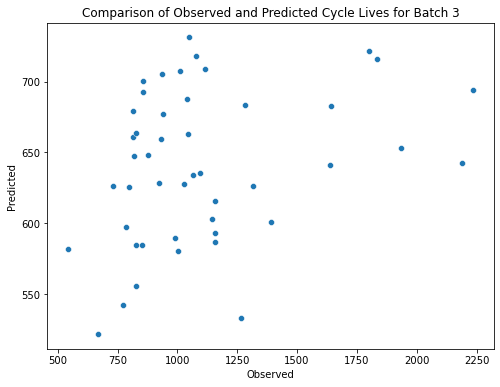

In [125]:
plt.figure(figsize=(8,6))
sns.scatterplot(observed, predicted)
plt.title("Comparison of Observed and Predicted Cycle Lives for Batch 3")
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.show()

Batch 3 introduces batteries with cycle lives of 1500+. Similarly to the model's poor performance on Batch 2 with cycle lives normalized between 400-500 cycle life, our model can not handle unseen data well.

We conclude with a final MAPE of __37%__.

# Conclusion<a class="anchor" id="chapter6"></a>

So we end with a final MAPE of 37%. As a reminder of the competition, the Stanford Research team achieve a final MAPE of 9.1%.

Does that mean that the project is a failure?

I would say no. Yes, the model is extremely limited in what it can achieve, compared to what can be achieved. Sure, it can only perform with the normalization and distribtion seen in Batch 1. And okay, the applications for the model are almost nonexistant.

But, the results do have some solid ground; we can see this in the scatter plots! While all of the batches are somewhat sparse and have similar upticks where predicted cycle life is significantly higher than observed cycle life, they all show a __general upward trend__. This means that, while the MAPE might be too high for practical use, the model can vaguely identify batteries with higher cycle life, and as cycle life goes up, so do the predictions. The model is able to pick up on __minute differences in degradation__ within 100 cycles (before any capacity degradation), and make grounded predictions off of them.

---

If I had the ability, I would include batteries with cycle lives of 300-500 in my training data to create a more balanced model.

However, credit where credit is due: The model that the Stanford Researchers used was trained on the same dataset and was still able to accurately predict the Batch 2 and Batch 3 batteries. I am intrigued by their use of Monte Carlo sampling and the formulation they used for regularization. I am also curious about their choice of features and their implementation of a target variable. Further research in battery mechanics as well as regression techniques is necessary to improve the model, but my results encourage me to seek that research.